In [1]:
#VQ-VAE--> Net 1
#VQE--> Net 2
#الف) شبکه اول دارای یک فضای نهان گسسته است که این فضا را قابل تفسیر میکند که برای دسترسی به دیتا مناسب میباشد. در حالی که در شبکه دوم این فضا پیوسته است و هر نقطه در فضا به کی دیتا مشخصی وابسته است. این فضا در مدل اول اجازه میدهد تا ساختارهای گسسته را به خوبی نمایش دهد و آنها را به صورت معنادارتری رمزگذاری کند. این شبکه میتواند نمونه هایی با کیفیت بالاتری تولید کند و بازنمایی های متنوع و منسجمی را ایجاد نماید. شبکه اول از کد بوک بهره میبرد که این کد بوک ها باعث همگرایی سریعتر و کاهش پیچیدگی محاسباتی میشود و برای دیتاهای بزرگ و یا در مواردی که فضای ذخیره سازی محدود است استفاده گردد.

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

In [36]:
class VQVAE(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )

        # Codebook
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        self.codebook.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def quantize(self, inputs):
        enc_reshaped = inputs.permute(0, 2, 3, 1)
        enc_reshaped = enc_reshaped.contiguous().view(-1, self.embedding_dim)
        distances = torch.cdist(enc_reshaped.unsqueeze(1), self.codebook.weight.unsqueeze(0))
        codes = torch.argmin(distances, dim=2)
        quantized = self.codebook(codes)
        quantized = quantized.view(*inputs.shape)

        return quantized, codes

    def forward(self, x):
        enc = self.encoder(x)
        quantized, codes = self.quantize(enc)
        dec = self.decoder(quantized)

        return dec, codes

In [37]:
def train(model, data_loader, optimizer, criterion, beta, device):
    model.train()
    total_loss = 0.0

    for inputs, _ in data_loader:
        inputs = inputs.to(device)
        optimizer.zero_grad()

        outputs, codes = model(inputs)

        recon_loss = criterion(outputs, inputs)
        commitment_loss = beta * torch.mean((inputs.detach() - outputs) ** 2)
        codebook_loss = torch.mean((inputs - outputs.detach()) ** 2)
        loss = recon_loss + commitment_loss + codebook_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [38]:
# Hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 1e-3
num_embeddings = 3
embedding_dim = 2
beta = 0.25

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Loading the MNIST dataset
train_dataset = MNIST(root="./data", train=True, transform=ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = VQVAE(num_embeddings, embedding_dim).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
codebook_vectors = []

# Training loop
costs = []
for epoch in range(num_epochs):
    loss = train(model, train_loader, optimizer, criterion, beta, device)
    costs.append(loss)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {loss:.4f}")
    if epoch == 0:
        with torch.no_grad():
            codebook = model.codebook.weight.data.cpu().numpy()
            codebook_vectors.append(codebook)

torch.save(model.state_dict(), "vqvae_mnist.pt")

Epoch 1/10 | Loss: 0.1796
Epoch 2/10 | Loss: 0.1839
Epoch 3/10 | Loss: 0.1886
Epoch 4/10 | Loss: 0.1894
Epoch 5/10 | Loss: 0.1898
Epoch 6/10 | Loss: 0.1899
Epoch 7/10 | Loss: 0.1899
Epoch 8/10 | Loss: 0.1900
Epoch 9/10 | Loss: 0.1900
Epoch 10/10 | Loss: 0.1900


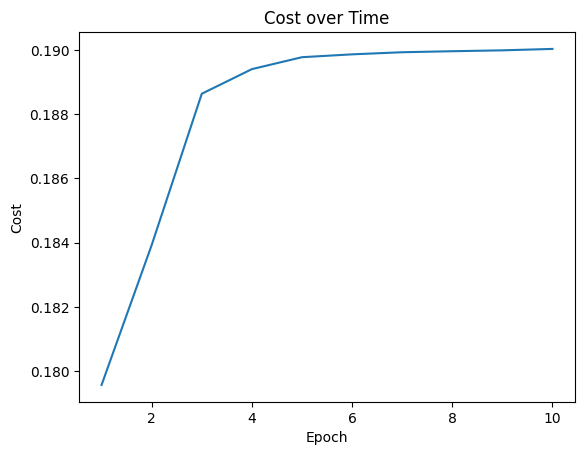

In [40]:
# Display the graph of cost over time
plt.plot(range(1, num_epochs + 1), costs)
plt.title("Cost over Time")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

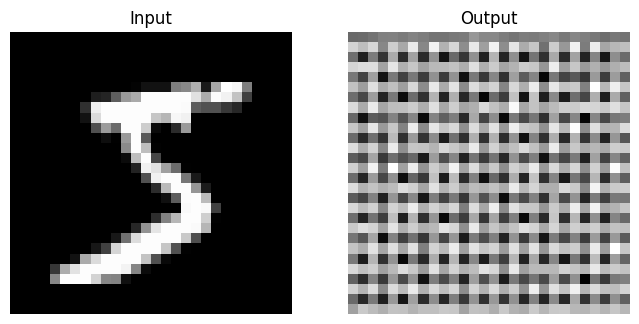

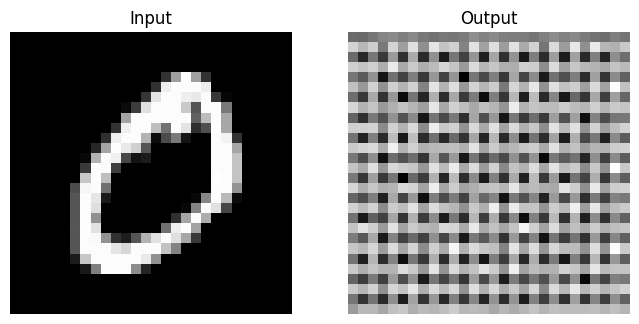

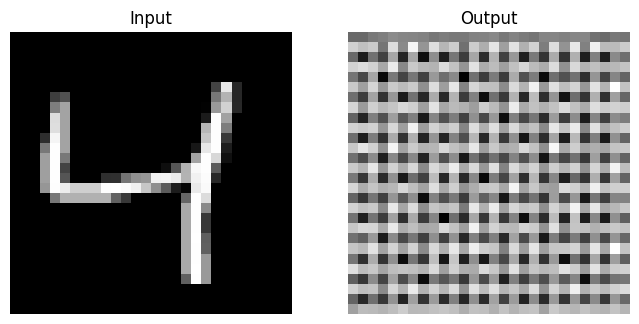

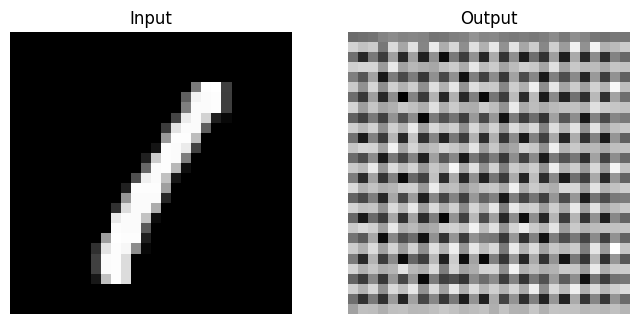

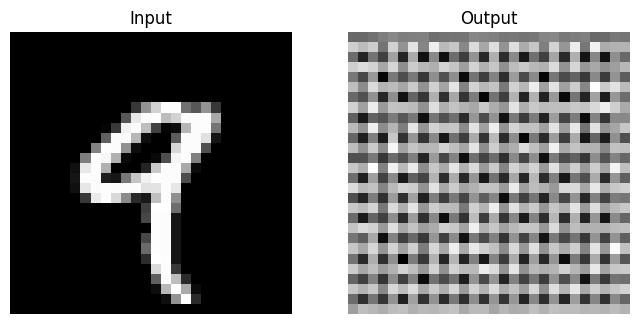

In [45]:
# Show input and output of the model for a number of inputs
num_inputs_to_show = 5
with torch.no_grad():
    for i in range(num_inputs_to_show):
        input_data, _ = train_dataset[i]
        input_data = input_data.unsqueeze(0).to(device)

        # Move the model's weights to the same device as the input data
        model = model.to(device)

        output, codes = model(input_data)

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.title("Input")
        plt.imshow(input_data.squeeze().cpu().numpy(), cmap="gray")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Output")
        plt.imshow(output.squeeze().cpu().numpy(), cmap="gray")
        plt.axis("off")

        plt.show()

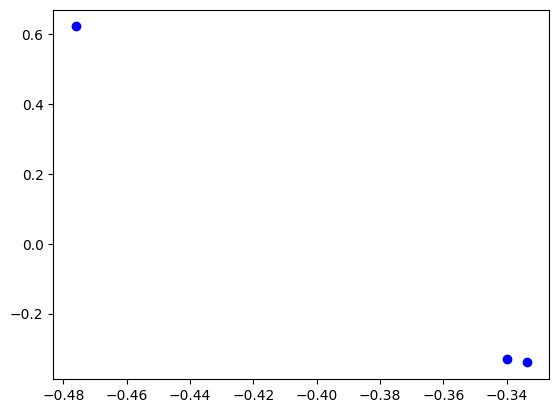

In [48]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
frames = []

for i, codebook_vector in enumerate(codebook_vectors):
    frame = ax.scatter(codebook_vector[:, 0], codebook_vector[:, 1], c='b', marker='o')
    frames.append(frame)

def update(frame):
    ax.clear()
    ax.scatter(frames[frame].get_offsets()[:, 0], frames[frame].get_offsets()[:, 1], c='b', marker='o')


animation = FuncAnimation(fig, update, frames=len(frames))
HTML(animation.to_jshtml())

In [54]:
import os
import torch
from torchvision import datasets
from torchvision.utils import save_image
import torchvision.utils as vutils

mnist_dataset = MNIST(root="./data", train=True, transform=ToTensor(), download=True)
def create_color_dataset(output_directory):
    os.makedirs(output_directory, exist_ok=True)

    for i, (image, _) in enumerate(mnist_dataset):
        random_numbers = torch.rand(3)
        color_image = torch.zeros((3, image.shape[1], image.shape[2]), dtype=torch.float32)
        for j in range(3):
            color_image[j] = image * random_numbers[j]

        output_path = os.path.join(output_directory, f"{i}.png")
        save_image(color_image, output_path)

output_directory = 'path/to/color_dataset'
create_color_dataset(output_directory)

def increase_num_vectors(model, data_loader, optimizer, criterion, beta, device):
    model.train()
    total_loss = 0.0

    for inputs, _ in data_loader:
        inputs = inputs.to(device)
        optimizer.zero_grad()

        outputs, codes = model(inputs)

        recon_loss = criterion(outputs, inputs)
        commitment_loss = beta * torch.mean((inputs.detach() - outputs) ** 2)
        codebook_loss = torch.mean((inputs - outputs.detach()) ** 2)
        loss = recon_loss + commitment_loss + codebook_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

from torchvision.utils import save_image

color_dataset = datasets.ImageFolder(root=output_directory, transform=transform)
data_loader = DataLoader(color_dataset, batch_size=batch_size, shuffle=True)

model = VQVAE(num_embeddings, embedding_dim).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    loss = increase_num_vectors(model, data_loader, optimizer, criterion, beta, device)
    print(f"اپوک {epoch + 1}: خطا = {loss}")


model.eval()
with torch.no_grad():
    for i in range(10):
        inputs, _ = next(iter(data_loader))
        inputs = inputs.to(device)

        outputs, _ = model(inputs)

        output_path = f"output_image_{i}.png"
        save_image(outputs, output_path)

def increase_vector_dimensions(model, data_loader, optimizer, criterion, beta, device):
    model.train()
    total_loss = 0.0

    for inputs, _ in data_loader:
        inputs = inputs.to(device)
        optimizer.zero_grad()

        outputs, codes = model(inputs)

        recon_loss = criterion(outputs, inputs)
        commitment_loss = beta * torch.mean((inputs.detach() - outputs) ** 2)
        codebook_loss = torch.mean((inputs - outputs.detach()) ** 2)
        loss = recon_loss + commitment_loss + codebook_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

color_dataset = datasets.ImageFolder(root=output_directory, transform=transform)
data_loader = DataLoader(color_dataset, batch_size=batch_size, shuffle=True)

model = VQVAE(num_embeddings, embedding_dim).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    loss = increase_vector_dimensions(model, data_loader, optimizer, criterion, beta, device)
    print(f"epoch{epoch + 1}: error= {loss}")

def generate_images(model, num_images, device):
    model.eval()
    with torch.no_grad():

        random_codes = torch.randint(0, model.num_embeddings, (num_images, model.embedding_dim)).to(device)
        reconstructions = model.decoder(random_codes.permute(0, 3, 1, 2))
        reconstructions = (reconstructions + 1) / 2
        grid = vutils.make_grid(reconstructions, nrow=int(num_images ** 0.5), padding=2, normalize=True)
        vutils.save_image(grid, 'generated_images.png')

generate_images(model, num_images=10, device=device)

NameError: name 'transform' is not defined